In [1]:
using Distributions
using Seaborn
import StatsBase: wsample
import Clustering: kmeans

In [11]:
include("src/auxiliary.jl")

gen_pairwise!

In [3]:
include("src/chmm.jl")

simulate_model (generic function with 1 method)

In [4]:
K = 3
KK = K^2
D = 2
model = rand_chmm(K, D)
T_range = 750:1_500
N_traj_pairs = 10
N_trajs = N_traj_pairs * 2
trajs = [simulate_model(model, rand(T_range)) for _ in 1:N_trajs] 
;

In [ ]:
traj_lens = map(t -> size(t[1], 2), trajs)
num_obs = sum(traj_lens) * 2

X = empty(D, num_obs)
Z = empty(Int, num_obs)
traj_ptr = empty(Int, N_trajs + 1)
pairs = Vector{NTuple{2, Int}}(N_traj_pairs)
;

In [23]:
idx = 1
for n in 1:N_traj_pairs
    (Zt, X1, X2) = trajs[n]
    T = size(Z, 2)
    
    start_1 = idx
    end_1 = start_1 + T - 1
    start_2 = end_1 + 1
    end_2 = start_2 + T - 1
    
    Z[start_1:end_1] = Zt[1, :]
    Z[start_2:end_2] = Zt[2, :]
    X[:, start_1:end_1] = X1
    X[:, start_2:end_2] = X2    
    
    # record the pairs
    traj_1 = sub2ind((2, N_traj_pairs), 1, n)
    traj_2 = traj_1 + 1
    traj_ptr[traj_1] = start_1
    traj_ptr[traj_2] = start_2
    pairs[n] = (traj_1, traj_2)
    
    idx = end_2
end    
;

In [24]:
pairs

10-element Array{Tuple{Int64,Int64},1}:
 (1, 2)  
 (3, 4)  
 (5, 6)  
 (7, 8)  
 (9, 10) 
 (11, 12)
 (13, 14)
 (15, 16)
 (17, 18)
 (19, 20)

## EM

In [16]:
# initial EM estiamtes 
R = kmeans(X, K, maxiter=100, display=:none)
ms = [R.centers[:, i] for i in 1:K]
Ss = [eye(D) for _ in 1:K]

# initial distribition over K × K
p0 = normalize(rand(K), 1)
p0 = (p0 * p0')[:]
log_p0 = log.(p0)

P = rand(K, KK)
P ./= sum(P, 1)
# make it K² × K²
# T[:, i] is symmetric if reshaped to be K×K, ∀i
P = repeat(P, inner=(K, 1)) .* repeat(P, outer=(K, 1))
log_P = log.(P)
;

In [19]:
# swap the indices of y ∈ [1, K²]
# if T is N×K², then T[:, swapped_indes] is the same as:
# `reshape(permutedims(reshape(T, (N, K, K)), [1, 3, 2]), (N, :))`
swapped_inds = [rev_ind(i, K) for i in 1:KK]
;

In [21]:
# T_max = maximum(diff(traj_ptr))
T_max = T
log_b = empty(KK, T_max)
log_α = similar(log_b)
log_β = similar(log_b)

α = similar(log_b)
β = similar(log_b)
γ = similar(log_b)
;

In [22]:
# data across for multiple trajectories
temp_P = zeros(P)
temp_p0 = zeros(p0)
pseudo_counts_K = zeros(K)
pseudo_counts_KK = zeros(KK)

temp_ms = deepcopy(ms)
temp_Ss = deepcopy(Ss)

temp = empty(KK)
temp2 = empty(temp_P)
;

In [23]:
N_iters = 50
log_like_hist = zeros(N_iters)
;

In [36]:
for iter in 1:N_iters    
    fill!(temp_P, 0)
    fill!(temp_p0, 0)
    fill!(pseudo_counts_K, 0)
    fill!(pseudo_counts_KK, 0)
    for k in 1:K
        fill!(temp_ms[k], 0)
        fill!(temp_Ss[k], 0)
    end
    
    #
    # Pairwise Trajectories
    #
#for (n, (s1, s2)) in enumerate(pairs)
#     start_1 = traj_ptr[s1]
#     end_1 = traj_ptr[s1+1]-1
#     start_2 = traj_ptr[s2]
#     end_2 = traj_ptr[s2] - 1
    
#     X1 = view(X, :, start_1:end_2)
#     X2 = view(X, :, start_2:end_2)
    T = size(X1, 2)
    @assert T == size(X2, 2)

    for t in 1:T
        o1 = X1[:, t]
        o2 = X2[:, t]
        for q in 1:K^2
            (i, j) = ind2sub((K, K), q)
            log_b[q, t] = logpdf(MvNormal(ms[i], Ss[i]), o1) +
                    logpdf(MvNormal(ms[j], Ss[j]), o2)
        end
    end

    # forward
    # temp is [ log_a[i, t-1] + log_A[j, i] ]ᵢ
    log_α[:, 1] = log_p0 .+ log_b[:, 1]

    for t in 2:T
        for j in 1:KK
            temp[:] = log_α[:, t-1]
            temp .+= log_P[j, :]
            log_α[j, t] = logsumexp(temp) + log_b[j, t]
        end
    end

    # backward pass
    # temp is [ log_A[i, j] + log_β[j, t+1] + log_b[j, t+1] ]ⱼ
    log_β[:, T] = 0

    for t in (T-1):-1:1
        for i in 1:KK
            temp[:] = log_b[:, t+1]
            temp .+= log_P[:, i]
            temp .+= log_β[:, t+1]
            log_β[i, t] = logsumexp(temp)
        end
    end

    # γ
    for t in 1:T
        γ[:, t] = log_α[:, t]
        γ[:, t] .+= log_β[:, t]
        γ[:, t] .-= logsumexp(γ[:, t])
    end
    map!(exp, γ, γ)

    log_like_hist[iter] = logsumexp(log_α[:, T])
    (iter % 10 == 0) && println(iter, " ", log_like_hist[iter])

    pseudo_counts_KK .+= vec(sum(γ[:, 1:T], 2))
    pseudo_counts_K .+= single_counts(pseudo_counts_KK, K)

    #
    # Parameter Updates
    #

    # ξ / P
    for t in 1:(T-1)
        temp2[:] = log_P
        temp2 .+= log_α[:, t]'
        temp2 .+= log_b[:, t+1]
        temp2 .+= log_β[:, t+1]
        temp2 .-= logsumexp(temp2)
        temp_P .+= exp.(temp2)
    end

    # π₀
    temp_p0 .+= γ[:, 1]

    # μ & Σ
    for t in 1:T
        p = reshape(γ[:, t], (K, K))
        o1 = X1[:, t]
        o2 = X2[:, t]

        for k in 1:K
            pz1 = sum(p[k, :])
            pz2 = sum(p[:, k])

            temp_ms[k] .+= pz1 * o1
            temp_Ss[k] .+= pz1 * o1 * o1'

            temp_ms[k] .+= pz2 * o2
            temp_Ss[k] .+= pz2 * o2 * o2'
        end
    end
#end
    
    #
    # Single Trajectories
    #
    
    #
    # combine info from all trajectories
    #
    
    temp_P .+= ϵ
    temp_P .+= temp_P[:, swapped_inds]
    temp_P ./= sum(temp_P, 1) 
    for i in 1:KK
        gen_pairwise!(view(P, :, i), estimate_outer(reshape(temp_P[:, i], K, K)))
    end
    map!(log, log_P, P)

    # go from p0 over K×K to just K
    gen_pairwise!(p0, estimate_outer(reshape(temp_p0 .+ ϵ, K, K)))
    p0 ./= sum(p0)
    map!(log, log_p0, p0)

    for k in 1:K
        ms[k][:] = temp_ms[k] ./ (pseudo_counts_K[k])
        Ss[k][:] = temp_Ss[k] ./ (pseudo_counts_K[k])
        Ss[k] .-= ms[k] * ms[k]'
        # to enforce symmetry
        Ss[k] .+= Ss[k]'
        Ss[k] ./= 2
    end
end

10 -6900.478781649449
20 -6900.478781649449
30 -6900.478781649449
40 -6900.478781649449
50 -6900.478781649449


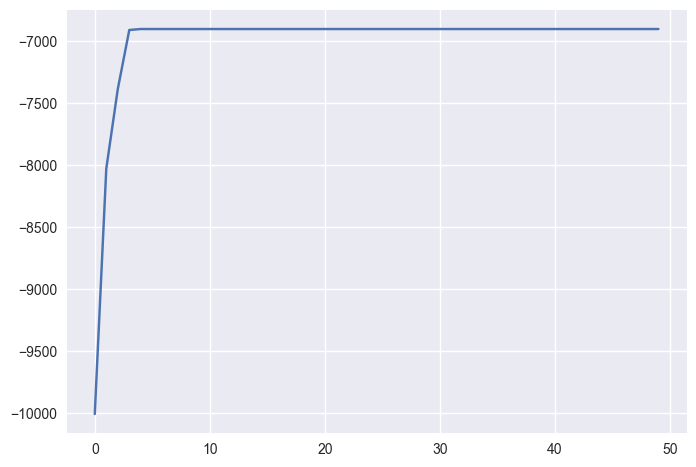

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000356689B0>

In [37]:
plot(log_like_hist)

In [46]:
true_to_est_lut = Dict{Int, Int}()
for i in 1:K
    m = model[:μs][i]
    r = map(mm -> norm(m .- mm), ms)
    true_to_est_lut[i] = indmin(r)
end
true_to_est_lut

Dict{Int64,Int64} with 3 entries:
  2 => 3
  3 => 1
  1 => 2

In [49]:
P_true = reshape(model[:P], K, KK)
P_true

3×9 Array{Float64,2}:
 0.00859482  0.0859447  0.226358  …  0.446952   0.00938702  0.633972
 0.592521    0.457251   0.306858     0.530738   0.305446    0.105512
 0.398884    0.456804   0.466785     0.0223101  0.685167    0.260516

In [51]:
reshape(P, :, K, K)

9×3×3 Array{Float64,3}:
[:, :, 1] =
 0.0557647  0.0725185  0.186643 
 0.152994   0.0921783  0.110184 
 0.0291712  0.105467   0.13833  
 0.152994   0.0921783  0.110184 
 0.419748   0.117168   0.0650472
 0.0800329  0.134059   0.0816625
 0.0291712  0.105467   0.13833  
 0.0800329  0.134059   0.0816625
 0.0152598  0.153386   0.102522 

[:, :, 2] =
 0.0725185  0.153737  0.0915632
 0.0921783  0.0       0.0422781
 0.105467   0.237767  0.171617 
 0.0921783  0.0       0.0422781
 0.117168   0.0       0.0195214
 0.134059   0.0       0.0792417
 0.105467   0.237767  0.171617 
 0.134059   0.0       0.0792417
 0.153386   0.367727  0.321661 

[:, :, 3] =
 0.186643   0.0915632  0.00654837
 0.110184   0.0422781  0.0386118 
 0.13833    0.171617   0.0357914 
 0.110184   0.0422781  0.0386118 
 0.0650472  0.0195214  0.227671  
 0.0816625  0.0792417  0.211041  
 0.13833    0.171617   0.0357914 
 0.0816625  0.0792417  0.211041  
 0.102522   0.321661   0.195625  

In [48]:
tt = similar(P_true)
for k in 1:KK
    i, j = ind2sub((K, K), k)
    ke = sub2ind((K, K), true_to_est_lut[i], true_to_est_lut[j])
    tt[:, i] = estimate_outer(reshape(P[:, true_to_est_lut[i]], K, K))
end
tt

3×9 Array{Float64,2}:
 0.269293  0.432022  0.236145  2.70876e-315  …  2.7084e-315   2.70838e-315
 0.342298  0.255043  0.64788   2.70841e-315     2.70837e-315  2.70838e-315
 0.391645  0.320191  0.12353   2.70841e-315     2.70837e-315  2.70801e-315

In [170]:
Z_obs = similar(Z)
for t in 1:T
    Z_obs[:, t] = [ind2sub((K, K), indmax(γ[:, t]))...]
end
sum(Z_obs .!= Z)

1922